<h2>CEO Characteristics and firm perfomance: evidence from Fortune 1000 companies</h2>
<h3>Goals</h3>
<ul>
    <li>Find patterns in CEO dataset and determine how CEO's characteristics affect company's performance</li>
    <li>Cluster CEOs into groups based on their prior work experience</li>
    <li>Study how CEOs differ in various sectors</li>
</ul>
<h3>Team: Milton Friedman</h3>
<ol>
    <li>Mikhail Mironov</li>
    <li>Vera Garmanova</li>
</ol>

<h3>About dataset</h3>
<p>Initially our dataset has been inspired by kaggle <a href="https://www.kaggle.com/datasets/winston56/fortune-500-data-2021">Fortune 1000 companies dataset</a>. It has some financial data on the companies such as profits, revenue, ticker (if company is publically traded) and some basic information on CEO of the company such as name and some other descriptive dummy variables. We decided to expand on this data, so we handcrafted our dataset with additional data on CEOs as we wanted to study them more closely. We used primarily Python for both data collection and analysis, some analysis has been done in R, since there is simply no implementation of some algorithms in Python.</p>

<h4>Data Collection techniques applied to the project</h4>
<ul>
    <li>Data on CEOs experience has been collected from LinkedIn profiles using Selenium</li>
    <li>Other data on age and salaries of CEOs has been collected from MorningStar using requests library</li>
</ul>

<h4>Data analysis techniques applied</h4>
<ul>
    <li>Principal Component Dimension reduction for plotting clusters and analysis with correlations</li>
    <li>Multidimensional Scaling using various distances: mainly focused on Euclidean and Manhattan</li>
    <li>Hierarchical clustering with various distances using scipy implementation</li>
    <li>Scree plot of distance between merged clusters to find optimal number of clusters for Hierarchical clustering</li>
    <li>Bootstrapping of Hierarchical clustering using pvclust module from R to check cluster stability</li>
    <li>Applying Euclidean KMeans with various linkage methods, mainly we focused on Ward and Complete</li>
    <li>WSS Scree plot and Calinski-Harabasz statistic to find optimal number of clusters</li>
    <li>Additionally we have applied Silhouette Analysis to study the separation distance between the resulting clusters</li>
    <li>After obtaining promising results from Manhattan Hierarchical clustering we went for KMeans with Manhattan distances as well</li>
    <li>Bootstrapping Kmeans to see how often KMeans assigns datapoints to same clusters</li>
</ul>

<img src="meme.png" width="400">
<h4>We ended up using Python but some of analysis has been done in R as well....</h4>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

%matplotlib inline

<h3>Preliminary analysis</h3>

In [2]:
df = pd.read_csv("output_data/project_data.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df.head()

company  rank  rank_change   revenue   profit  num_employees  \
0            Walmart     1          0.0  572754.0  13673.0      2300000.0   
1             Amazon     2          0.0  469822.0  33364.0      1608000.0   
2         CVS Health     4          0.0  292111.0   7910.0       258000.0   
3           McKesson     9         -2.0  238228.0  -4539.0        67500.0   
4  AmerisourceBergen    10         -2.0  213988.8   1539.9        40000.0   

        sector  ceo_woman                  ceo ticker  ...  \
0    Retailing          0  C. Douglas McMillon    WMT  ...   
1    Retailing          0      Andrew R. Jassy   AMZN  ...   
2  Health Care          1          Karen Lynch    CVS  ...   
3  Health Care          0       Brian S. Tyler    MCK  ...   
4  Health Care          0     Steven H. Collis    ABC  ...   

   months_ceo_company months_company  months_company_others  num_followers  \
0                 166            166                     42        1136161   
1                 308            308                      0         354740   
2                  22             49                    258         285180   
3                  44            311                    177          29374   
4                 143            347                      0          83467   

   num_comp  profit_ratio   age  total_compensation     salary  \
0         2      0.023872  55.0          25670672.0  1276892.0   
1         1      0.071014  54.0         212701170.0   175000.0   
2         6      0.027079  59.0           7045167.0  1429167.0   
3         4     -0.019053  55.0          18152082.0  1375000.0   
4         1      0.007196  60.0          14873815.0  1400000.0   

   restricted_stock  
0        19195008.0  
1       211933520.0  
2               NaN  
3        12250438.0  
4        10500201.0  

[5 rows x 22 columns]

<p>In the future we might want to study how ceos differ from each other in different sectors. So now we will encode sectors and maybe group some of them together so we dont have that many sectors. Based on the table below we will take 6 or 7 biggest sectors by revenue and combine others into one.</p>
<ol>
    <li>Food and Drug Store</li>
    <li>Telecommunications</li>
    <li>Health Care</li>
    <li>Retailing</li>
    <li>Aerospace and Defense</li>
    <li>Motor Vehicles and Parts</li>
    <li>Financials</li>
    <li>Food, Beverages and Tobacco</li>
</ol>

In [3]:
by_sector = df.groupby(
    "sector"
)["revenue"].agg(["min", "mean", "max", "count"]).sort_values(by="mean", ascending=False)

sectors_left = by_sector.index[:8]
by_sector.head(8)

min          mean       max  count
sector                                                          
Food & Drug Stores         6099.9  77260.140000  148579.0      5
Telecommunications         6411.0  44586.780000  168864.0      5
Health Care                2225.1  39827.402174  292111.0     46
Retailing                  2122.2  39232.384211  572754.0     38
Aerospace & Defense        2124.1  21408.650000   64388.0      6
Motor Vehicles & Parts     2773.0  20446.630000  127004.0     10
Financials                 2112.8  18674.603077  127202.0     65
Food, Beverages & Tobacco  3461.0  17045.266667   79474.0     18

In [4]:
df.sector = df.sector.apply(lambda x: x if x in sectors_left else "Others")

In [5]:
cols = [
    "company", "sector",
    "revenue", "profit", "months_ceo_company",
    "months_company", "months_company_others", "age",
    "num_comp", "num_followers", "total_compensation", "salary"
]

df_num = df[cols].copy()
df_num = df_num.dropna()
df_num.reset_index(inplace=True, drop=True)
df_num.sector = df_num.sector.astype("category")
df_clear = df_num.copy()

<h3>Histograms</h3>
<p>Since some of our data has log-normal distribution, we should take a log of our data.</p>

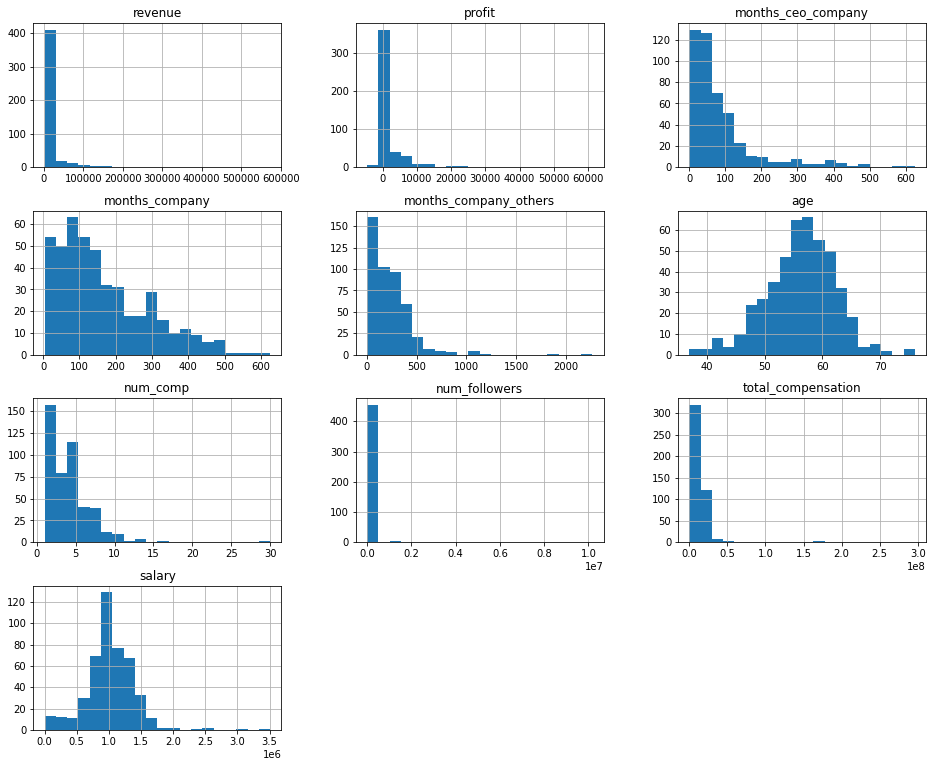

In [6]:
df_num.iloc[:, 2:].hist(bins=20, figsize=(16,13))
plt.show()

In [7]:
# Transform data to prevent having 0 and negatives in logs
# profit + 1 - min(profit)
cols_log_norm = [
    "revenue", "profit", "months_ceo_company", "months_company",
    "months_company_others", "num_comp", "num_followers", "total_compensation"
]

df_num.profit = df_num.profit + 1 - df_num.profit.min() # eliminate negative profits
df_num.months_company_others = df_num.months_company_others + 1 # eliminate zero experience in other companies
df_num.num_followers += 1 
df_num.head()

company       sector   revenue   profit  months_ceo_company  \
0            Walmart    Retailing  572754.0  18213.0                 166   
1             Amazon    Retailing  469822.0  37904.0                 308   
2         CVS Health  Health Care  292111.0  12450.0                  22   
3           McKesson  Health Care  238228.0      1.0                  44   
4  AmerisourceBergen  Health Care  213988.8   6079.9                 143   

   months_company  months_company_others   age  num_comp  num_followers  \
0             166                     43  55.0         2        1136162   
1             308                      1  54.0         1         354741   
2              49                    259  59.0         6         285181   
3             311                    178  55.0         4          29375   
4             347                      1  60.0         1          83468   

   total_compensation     salary  
0          25670672.0  1276892.0  
1         212701170.0   175000.0  
2           7045167.0  1429167.0  
3          18152082.0  1375000.0  
4          14873815.0  1400000.0

In [8]:
df_num[cols_log_norm] = df_num[cols_log_norm].apply(np.log)
df_num.head()

company       sector    revenue     profit  months_ceo_company  \
0            Walmart    Retailing  13.258212   9.809891            5.111988   
1             Amazon    Retailing  13.060109  10.542812            5.730100   
2         CVS Health  Health Care  12.584889   9.429476            3.091042   
3           McKesson  Health Care  12.380983   0.000000            3.784190   
4  AmerisourceBergen  Health Care  12.273679   8.712744            4.962845   

   months_company  months_company_others   age  num_comp  num_followers  \
0        5.111988               3.761200  55.0  0.693147      13.943166   
1        5.730100               0.000000  54.0  0.000000      12.779143   
2        3.891820               5.556828  59.0  1.791759      12.560879   
3        5.739793               5.181784  55.0  1.386294      10.287899   
4        5.849325               0.000000  60.0  0.000000      11.332219   

   total_compensation     salary  
0           17.060860  1276892.0  
1           19.175399   175000.0  
2           15.767852  1429167.0  
3           16.714296  1375000.0  
4           16.515113  1400000.0

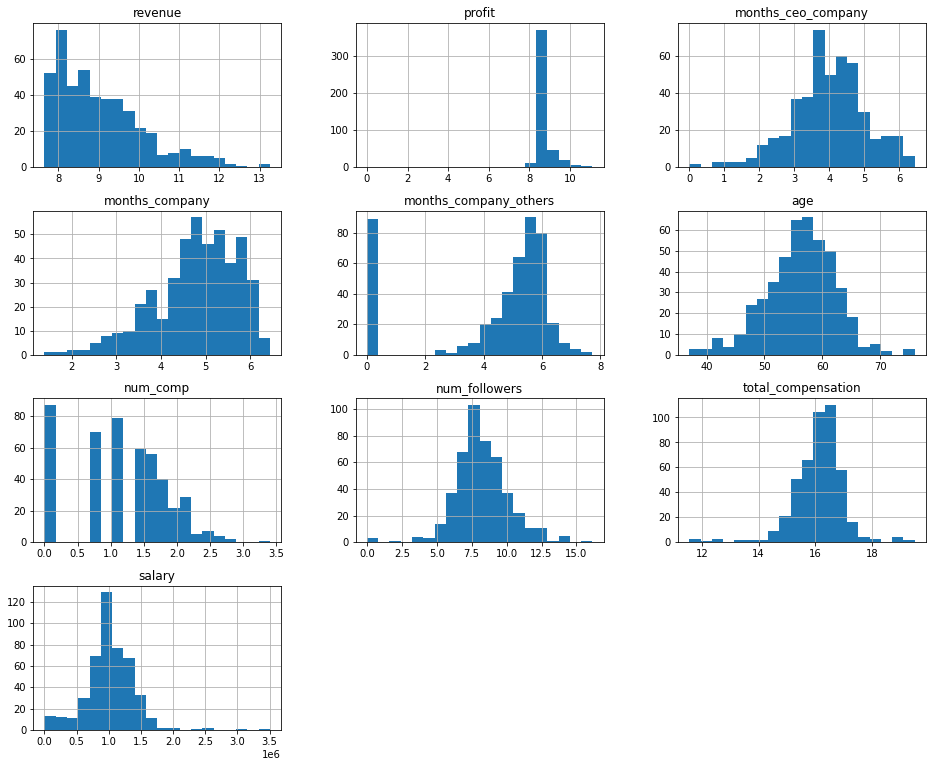

In [9]:
df_num.iloc[:, 2:].hist(bins=20, figsize=(16, 13))
plt.show()

In [10]:
df_clear["profit_ratio"] = df_clear.profit / df_clear.revenue

In [11]:
from sklearn.preprocessing import StandardScaler

df_num.columns

Index(['company', 'sector', 'revenue', 'profit', 'months_ceo_company',
       'months_company', 'months_company_others', 'age', 'num_comp',
       'num_followers', 'total_compensation', 'salary'],
      dtype='object')

In [12]:
columns_analysis = [
    "revenue", "profit", "months_ceo_company", "months_company", "months_company_others", 
    "age", "num_comp", "num_followers", "total_compensation"
]

X = df_num[columns_analysis].to_numpy()
Xs = StandardScaler().fit_transform(X)

<h3>PCA plot of our data</h3>

<p>Following this, we will use PCA of 3 components. We will once plot 3d PCA plot to see what are the final results, but throughtout our analysis we will just use two projections: PC1 onto PC2 and PC2 onto PC3</p>

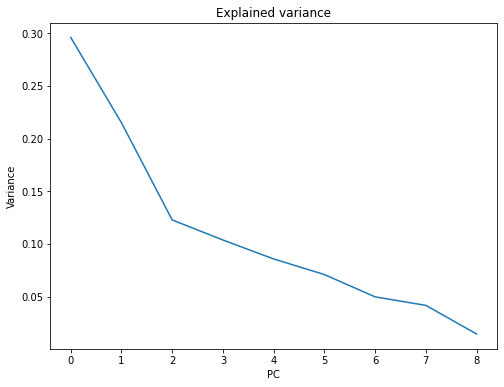

In [13]:
pca = PCA(n_components=Xs.shape[1]).fit(Xs)

# Explained variance by n-th PCS
plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance")
plt.ylabel("Variance")
plt.xlabel("PC")
plt.show()

In [14]:
print("Total variance explained by 3 PCs is {:.2f}".format(pca.explained_variance_ratio_[0:3].sum()))

Total variance explained by 3 PCs is 0.63


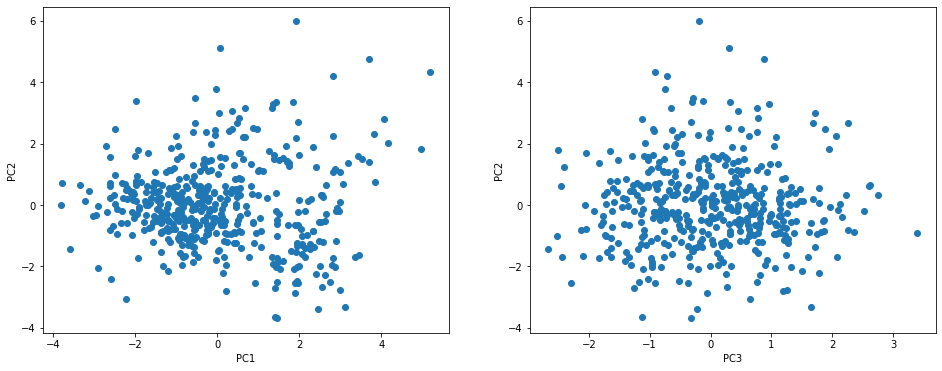

In [15]:
PCA_proj = pca.transform(Xs)

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.scatter(PCA_proj[:, 0], PCA_proj[:, 1])
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")

ax2 = fig.add_subplot(122)
ax2.scatter(PCA_proj[:, 2], PCA_proj[:, 1])
ax2.set_xlabel("PC3")
ax2.set_ylabel("PC2")

plt.show()

In [16]:
# Save to dataframe to further map clusters to pca
df_pca = pd.DataFrame(PCA_proj)
df_pca.columns = [f"PC{i}" for i in range(1, df_pca.shape[1]+1)]
df_pca.index = df_num.company
df_pca.head()

PC1       PC2       PC3       PC4        PC5  \
company                                                                
Walmart            2.817386  4.193409 -0.719311  1.407475  -0.010241   
Amazon             5.191283  4.345079 -0.904855  0.614538   0.439582   
CVS Health        -0.026076  3.781913 -0.741549  0.263056  -0.922882   
McKesson          -2.207127 -3.072734  0.643116  0.103039  11.401018   
AmerisourceBergen  3.708336  1.392797 -0.851258  0.381502   0.730546   

                        PC6       PC7       PC8       PC9  
company                                                    
Walmart            0.635540  0.193904 -1.295713 -0.120898  
Amazon            -1.542620  0.434106 -0.750661  0.340730  
CVS Health         1.764441  0.078480 -1.090591  0.416741  
McKesson           7.799677  3.587215 -1.357102  0.121737  
AmerisourceBergen  1.498264  0.283082 -0.931220  0.362211

<h3>Principal Components Correlations</h3>

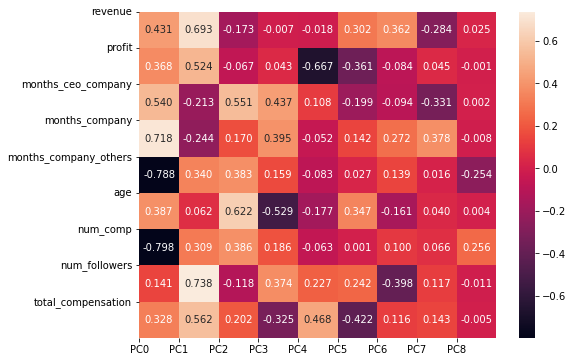

In [17]:
# Find correlation matrix of initial data matrix Xs and PCs
ncol = Xs.shape[1]
Corr = np.zeros((ncol, ncol))
for i in range(ncol):
    for j in range(ncol):
        Corr[i, j] = (Xs[:, i] @ PCA_proj[:, j]) / (Xs.shape[0] * Xs[:, i].std() * PCA_proj[:, j].std())
        
plt.figure(figsize=(8, 6))
ax = sns.heatmap(Corr, annot=True, fmt=".3f")
ax.set_xticks(ticks=range(ncol), labels=[f"PC{i}" for i in range(ncol)])
ax.set_yticks(ticks=range(ncol), labels=columns_analysis, rotation="horizontal")
plt.show()

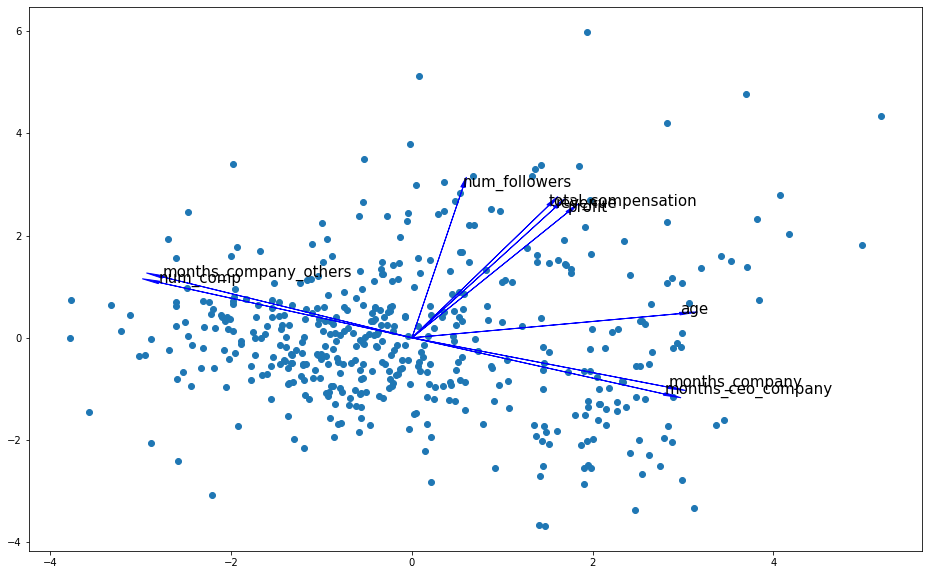

In [18]:
plt.figure(figsize=(16,10))
plt.scatter(PCA_proj[:, 0], PCA_proj[:, 1])

for i, col in enumerate(columns_analysis):
    V_norm = Corr[i, 0:2] / np.linalg.norm(Corr[i, 0:2]) * 3
    plt.annotate(col, V_norm, fontsize=15)
    plt.arrow(0, 0, *V_norm, head_width=0.05, head_length=0.2, color="blue")

plt.show()

<h3>MDS applied to our data with various distances</h3>
</br>
<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist">SciPy docs distances</a>

In [19]:
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform

<h3>Non-metric MDS</h3>

In [20]:
MDS_non_metric = MDS(
    n_components=3, 
    metric=False, 
    n_init=10, 
    max_iter=1000, 
    verbose=1,
    eps=1e-4,
    n_jobs=-1, 
    random_state=42
)

non_metric_res = MDS_non_metric.fit_transform(Xs)

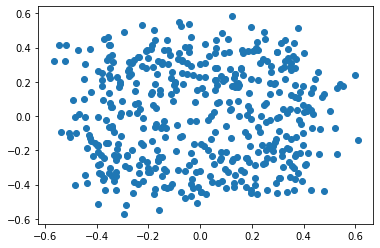

In [21]:
plt.scatter(non_metric_res[:, 0], non_metric_res[:, 1])
plt.show()

<h3>Eclidean distances</h3>

In [22]:
MDS_euclidean = MDS(
    n_components=3, 
    metric=True, 
    n_init=10, 
    max_iter=1000, 
    verbose=1,
    eps=1e-4,
    n_jobs=-1, 
    random_state=42, 
    dissimilarity='precomputed'
)

In [23]:
euclidean_dist = squareform(pdist(Xs, metric="euclidean"))
Euclidean_res = MDS_euclidean.fit_transform(euclidean_dist)

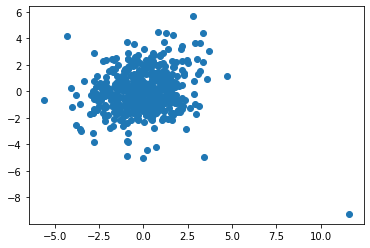

In [24]:
plt.scatter(Euclidean_res[:, 0], Euclidean_res[:, 1])
plt.show()

<h4>Shephard plot to figure optimal number of coordinates</h4>
<p>Further down the line we will use these projections to plot clusters data, so we might need to check if 3 dimensions are good enough for further analysis</p>

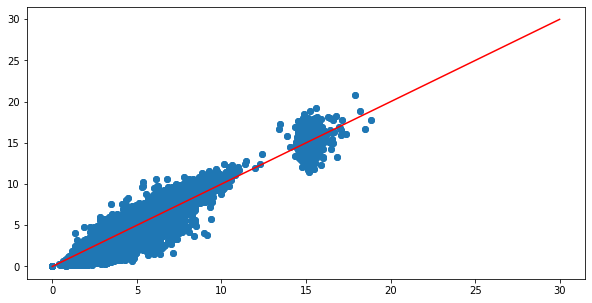

In [25]:
plt.figure(figsize=(10, 5))
projected_dist = squareform(pdist(Euclidean_res, metric="euclidean"))

plt.scatter(euclidean_dist, projected_dist)
abline_xy = np.arange(0, 30, 0.01)

plt.plot(abline_xy, abline_xy, color="red")
plt.show()

<h3>Manhattan distances</h3>
<p>From now on we will use precomputed distances from scipy module</p>

In [26]:
MDS_manhattan = MDS(
    n_components=3, 
    metric=True, 
    n_init=10, 
    max_iter=1000, 
    verbose=1,
    eps=1e-4,
    n_jobs=-1, 
    random_state=42, 
    dissimilarity='precomputed'
)

In [27]:
manhattan_dist = squareform(pdist(Xs, metric="cityblock"))
Manhattan_res = MDS_manhattan.fit_transform(manhattan_dist)

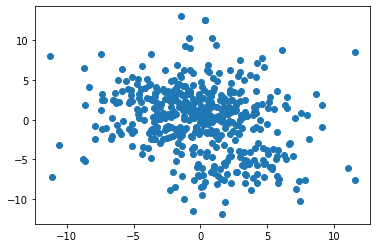

In [28]:
plt.scatter(Manhattan_res[:, 0], Manhattan_res[:, 1])
plt.show()

<h3>Mahalanobis distance</h3>

In [29]:
MDS_mahalanobis = MDS(
    n_components=3, 
    metric=True, 
    n_init=10, 
    max_iter=1000, 
    verbose=1,
    eps=1e-4,
    n_jobs=-1, 
    random_state=42, 
    dissimilarity='precomputed'
)

In [30]:
mahalanobis_dist = squareform(pdist(Xs, metric="mahalanobis"))
Mahalanobis_res = MDS_mahalanobis.fit_transform(mahalanobis_dist)

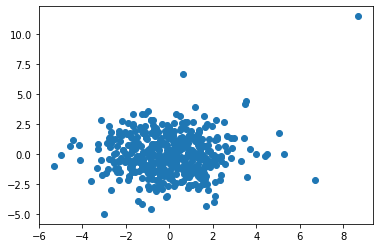

In [31]:
plt.scatter(Mahalanobis_res[:, 0], Mahalanobis_res[:, 1])
plt.show()

<h2>3. Applying various clustering techniques</h2>

<h3>3.1 Hierarchical clustering</h3>
</br>
<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html">Various linkage methods and their documentation on SciPy</a>

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial import ConvexHull
from scipy import interpolate

<p>Using hierarchical clustering we are to choose multiple hyperparameters such as linkage method and distance metric.</p>

<h3>Ward linkage with Euclidean distances</h3>

<p>Now we will plot distances between merged clusters. Similarily with a scree plot, if there is a hige spike, it implies that we shouldn't combine two clusters and we should stop uprooting the tree.</p>

In [33]:
# As we are going to plot scree plots multiple times let's define a function for it
def hclust_plot_scree(dist_clusters, lb, rb):
    
    if rb == "MAX":
        rb = len(dist_clusters)
        
    fig = plt.figure(figsize=(16, 8))
    
    ax1 = fig.add_subplot(121)
    ax1.plot(dist_clusters)
    ax1.set_title("Distance between merged clusters")
    ax1.set_xlabel('Merge step')
    ax1.set_ylabel('Distance')

    ax2 = fig.add_subplot(122)

    ax2.set_title("Absolute change in distances between merged clusters")
    ax2.set_xlabel("Merge step")
    ax2.set_ylabel("Change in merge distance")

    # Define absolute change in distance
    abs_change = np.array([
        dist_clusters[i] - dist_clusters[i-1]
        for i in range(1, dist_clusters.shape[0])
    ])
    
    rel_change = np.array([
        (dist_clusters[i] - dist_clusters[i-1]) / dist_clusters[i-1]
        for i in range(1, dist_clusters.shape[0])
    ])
    
    print(f"Maximum absolute change occurred at index: {abs_change.argmax()-1}")
    print(f"Maximum relative change occurred at index: {rel_change.argmax()-1}")

    ax2.plot(range(lb+1, rb), abs_change[lb: rb])

    plt.show()
    

def plot_dendrogram(critical_dist):
    
    plt.figure(figsize=(16, 6))

    _ = dendrogram(
        link,
        orientation='top',
        color_threshold = critical_dist,
        no_labels=True
    )

    plt.show()

In [34]:
# Calculate linkage distances between newly formed clusters. Here we can use all metrics from SciPy
link = linkage(Xs, 'ward', 'euclidean')
dist_clusters = link[:, 2] # -> distance between clusters

Maximum absolute change occurred at index: 456
Maximum relative change occurred at index: 456


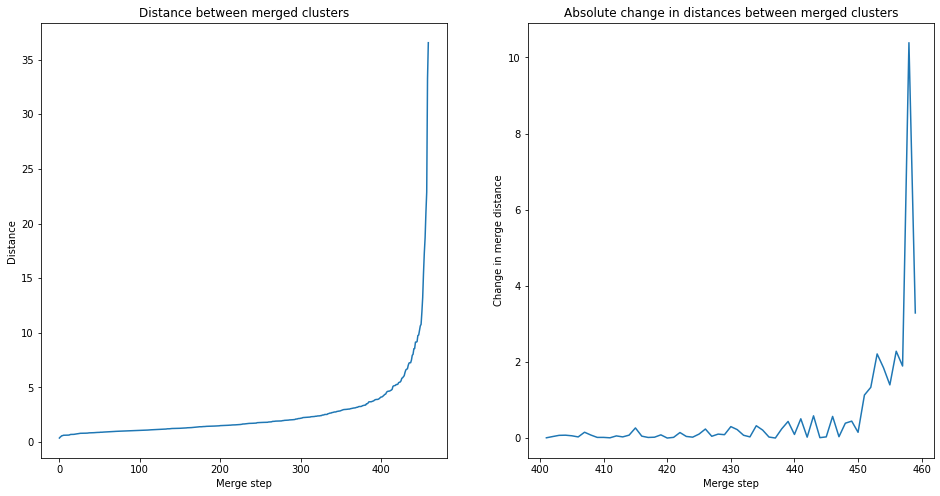

In [35]:
hclust_plot_scree(dist_clusters, lb=400, rb="MAX")

<p>As we can see from the plot above, we sould stop at 450-460-ish step, as the distance between merged starts to increase more rapidly</p>

In [36]:
critical_dist = dist_clusters[456]
print(f"At this distance between the remaining clusters we should cut tree: {critical_dist}")

At this distance between the remaining clusters we should cut tree: 20.976026378687095


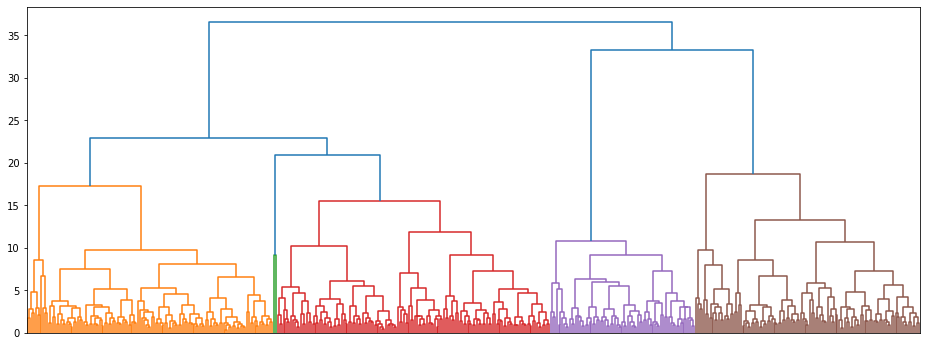

In [37]:
# Plot the tree and color clusters according to the found critical distance between clusters
plot_dendrogram(critical_dist)

In [38]:
# Cut tree and get clusters using the critical distance we found
assigned_clusters = fcluster(link, critical_dist, criterion='distance')
df_pca["hclust_ward"] = assigned_clusters

<h3>Centroid linkage with Euclidean distances</h3>

In [39]:
link = linkage(Xs, 'centroid', 'euclidean')
dist_clusters = link[:, 2] # -> distance between clusters

Maximum absolute change occurred at index: 457
Maximum relative change occurred at index: 457


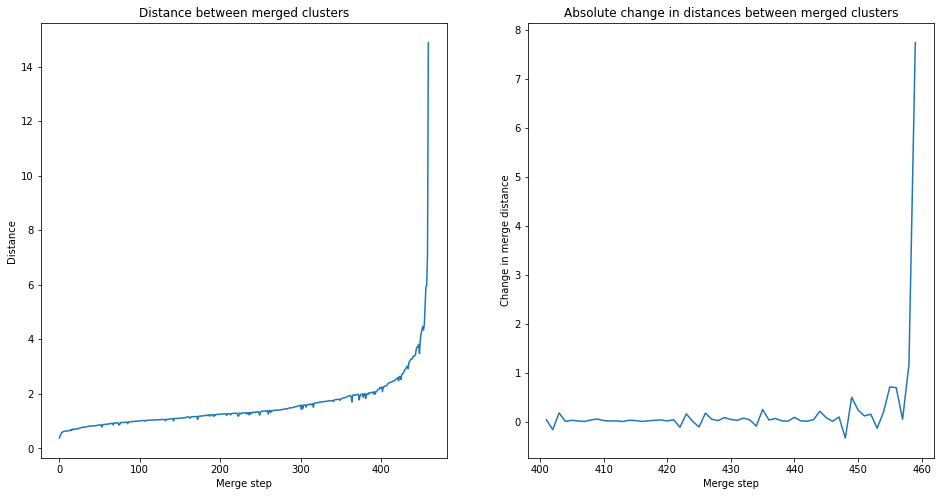

In [40]:
hclust_plot_scree(dist_clusters, lb=400, rb="MAX")

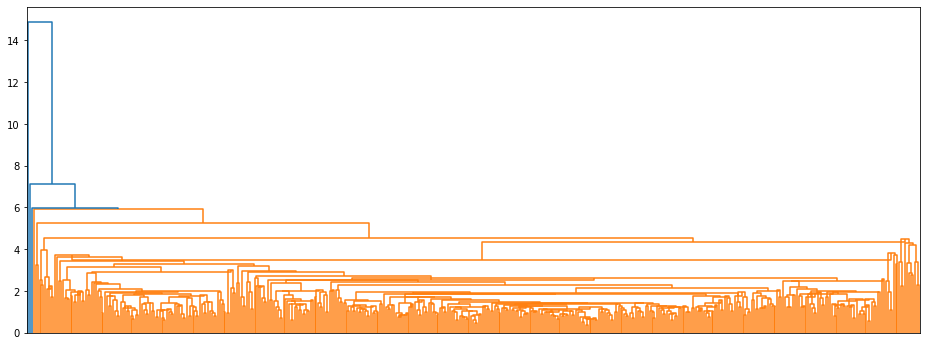

In [41]:
critical_dist = dist_clusters[457]
plot_dendrogram(critical_dist)

In [42]:
df_pca["hclust_centroid"] = fcluster(link, critical_dist, criterion='distance')

<h3>Complete linkage with Manhattan distances</h3>

In [43]:
link = linkage(Xs, 'complete', 'cityblock')
dist_clusters = link[:, 2] # -> distance between clusters

Maximum absolute change occurred at index: 456
Maximum relative change occurred at index: -1


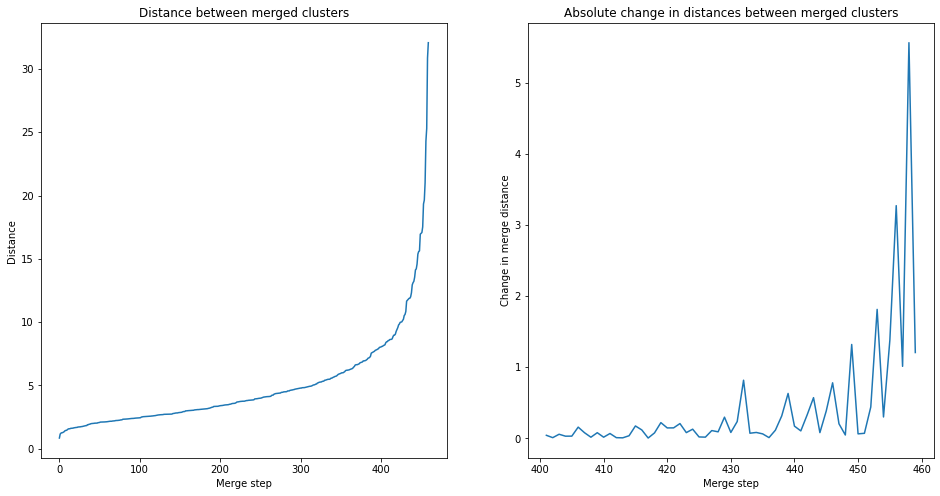

In [44]:
hclust_plot_scree(dist_clusters, lb=400, rb="MAX")

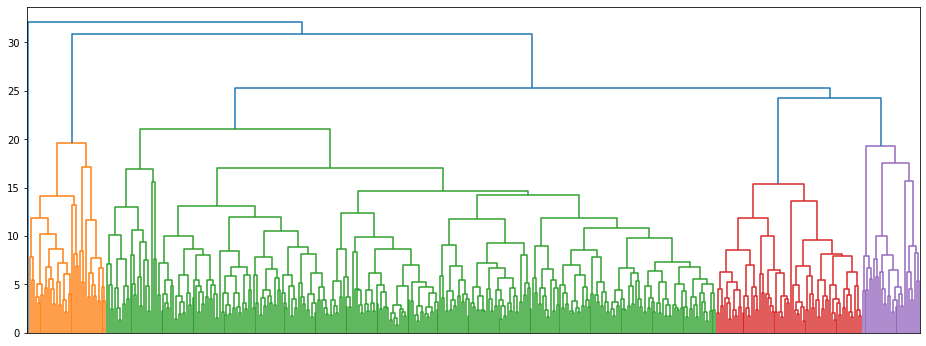

In [45]:
critical_dist = dist_clusters[456]
plot_dendrogram(critical_dist)

In [46]:
df_pca["hclust_complete_manhattan"] = fcluster(link, critical_dist, criterion='distance')

<h3>Median linkage with Euclidean distances</h3>

In [47]:
link = linkage(Xs, 'median', 'euclidean')
dist_clusters = link[:, 2] # -> distance between clusters

Maximum absolute change occurred at index: 457
Maximum relative change occurred at index: 457


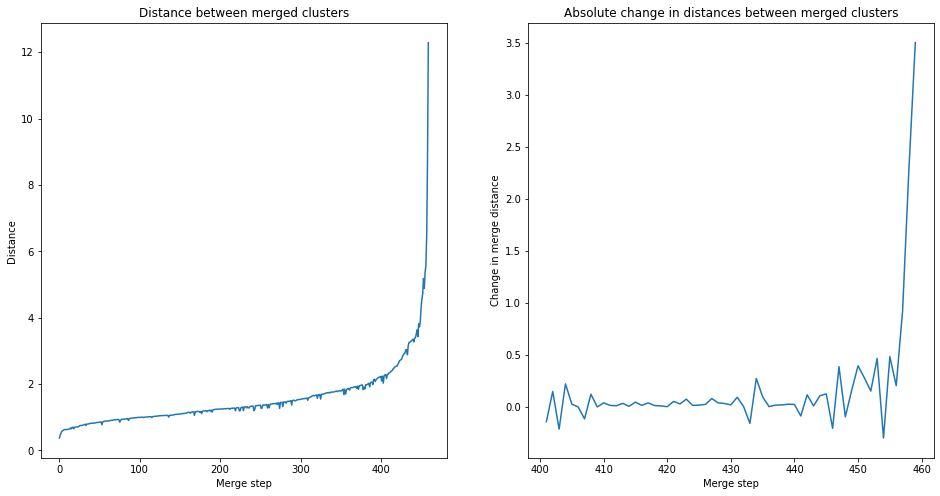

In [48]:
hclust_plot_scree(dist_clusters, lb=400, rb="MAX")

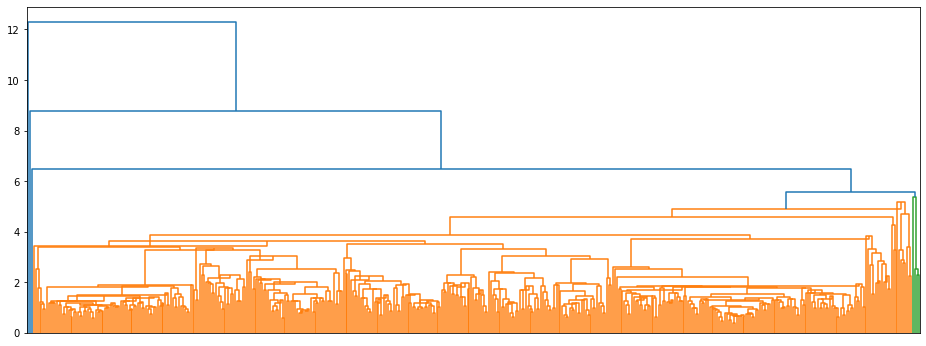

In [49]:
critical_dist = dist_clusters[456]
plot_dendrogram(critical_dist)

In [50]:
df_pca["hclust_median"] = fcluster(link, critical_dist, criterion='distance')

<h3>Boostraping with PVClust library from R to evaluate uncertainty in hierarchical clustering</h3>
</br>
<a href="https://github.com/aturanjanin/pvclust">Implementation of pvclust package in Python</a>

In [51]:
# there is no distribution on PyPi so I just cloned the repo
from src.pvclust import PvClust

In [52]:
pv = PvClust(pd.DataFrame(Xs), method="ward", metric="euclidean", nboot=1000, parallel=True)

Calculating using 4 cores... Done.


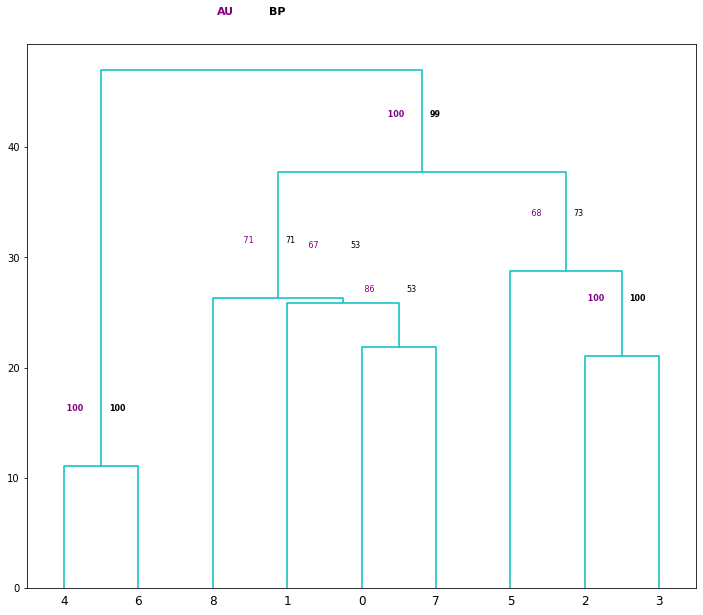

In [53]:
pv.plot()

<h3>Hclustering mapped to scatter plot</h3>

<h4>Plot for ward linkage with euclidean distances</h4>

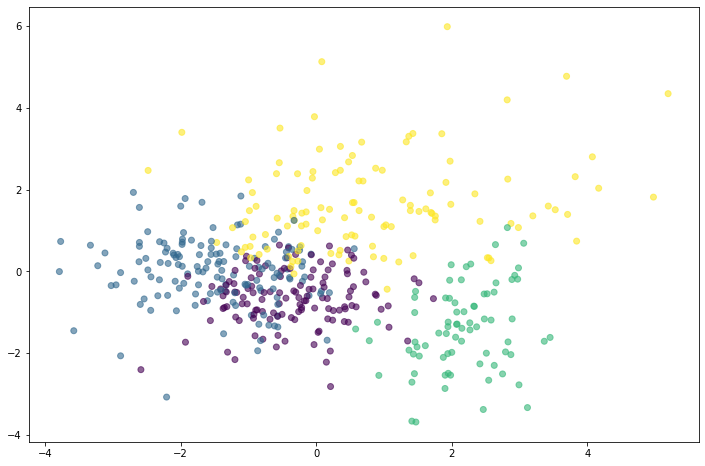

In [54]:
# Plot results using PC plot
plt.figure(figsize=(12,8))
plt.scatter(PCA_proj[:, 0], PCA_proj[:, 1], c = df_pca["hclust_ward"], alpha=0.6)
plt.show()

<h4>Adding halo to clusters to see spread of clusters more clearly</h4>

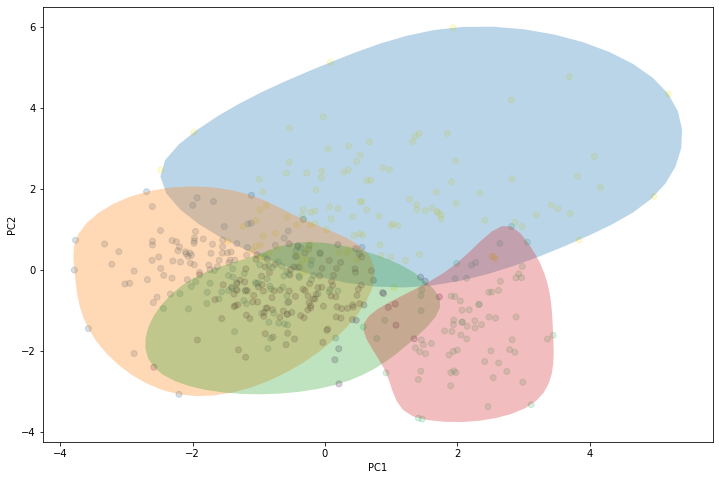

In [55]:
# Plot results using PC plot
plt.figure(figsize=(12,8))

plt.scatter(PCA_proj[:, 0], PCA_proj[:, 1], c = assigned_clusters, alpha = 0.2)
plt.xlabel("PC1")
plt.ylabel("PC2")

for i in df_pca["hclust_ward"].unique():
    points = df_pca[df_pca["hclust_ward"] == i][["PC1", "PC2"]].values
    hull = ConvexHull(points)
    x_hull = np.append(
        points[hull.vertices,0],
        points[hull.vertices,0][0]
    )
    y_hull = np.append(
        points[hull.vertices,1],
        points[hull.vertices,1][0]
    )
    
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep(
        [x_hull, y_hull], 
        u=dist_along, s=0, per=1
    )
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    
    # plot shape
    plt.fill(interp_x, interp_y, alpha=0.3)
    
plt.show()

<h4>Manhattan distances with complete linkage on MDS manhattan plot</h4>

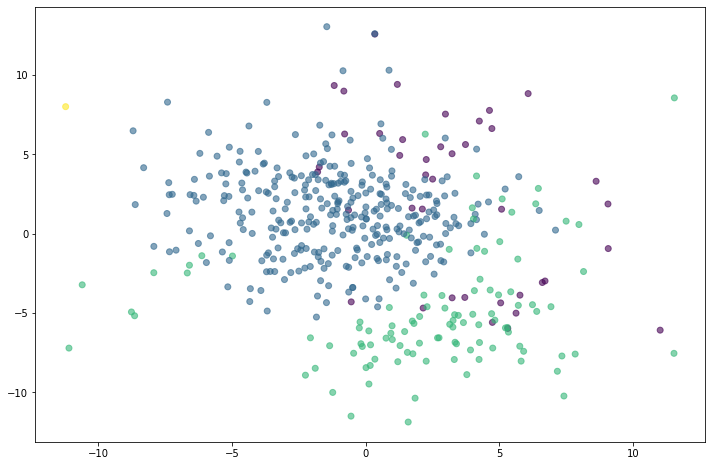

In [56]:
plt.figure(figsize=(12,8))
plt.scatter(Manhattan_res[:, 0], Manhattan_res[:, 1], c = df_pca["hclust_complete_manhattan"], alpha=0.6)
plt.show()

<h3>3.2 Clustering using KMeans</h3>

<p>In order to choose optimal number of clusters we will use both WSS and Calinski-Harabasz statistics</p>

In [57]:
WSS, CH = [], []

for i in tqdm(range(3, 20)):
    kmeans = KMeans(
        n_clusters=i, n_init=1000, max_iter=1000, tol=1e-4
    ).fit(Xs)
    groups = kmeans.predict(Xs)
    calinski_score = calinski_harabasz_score(Xs, groups) # implementation from sklearn
    WSS.append(kmeans.inertia_)
    CH.append(calinski_score)

100%|███████████████████████████████████████████| 17/17 [01:49<00:00,  6.43s/it]


<p>Do a scree plot for each number of clusters obtained by KMeans</p>

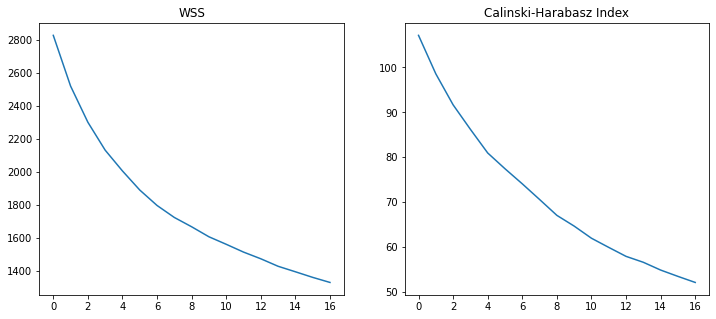

In [58]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)
ax1.plot(WSS)
ax1.set_title("WSS")

ax2 = fig.add_subplot(122)
ax2.plot(CH)
ax2.set_title("Calinski-Harabasz Index")

plt.show()

<p><b>WSS and CH Index: </b>We can not say for sure which number of clusters is optimal. In line with hierrhical cluster analysis it might be somewhere from 3 to 7.</p>

<h3>Silhoette analysis. Study how clusters are located next to each other:</h3>
<p>Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.</p>

In [59]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm

For n_clusters = 2 The average silhouette_score is : 0.1731016500286378
For n_clusters = 3 The average silhouette_score is : 0.13636134170581232
For n_clusters = 4 The average silhouette_score is : 0.1154953377121358
For n_clusters = 5 The average silhouette_score is : 0.12240795372951188
For n_clusters = 6 The average silhouette_score is : 0.09278892725354006
For n_clusters = 7 The average silhouette_score is : 0.06973300122910817


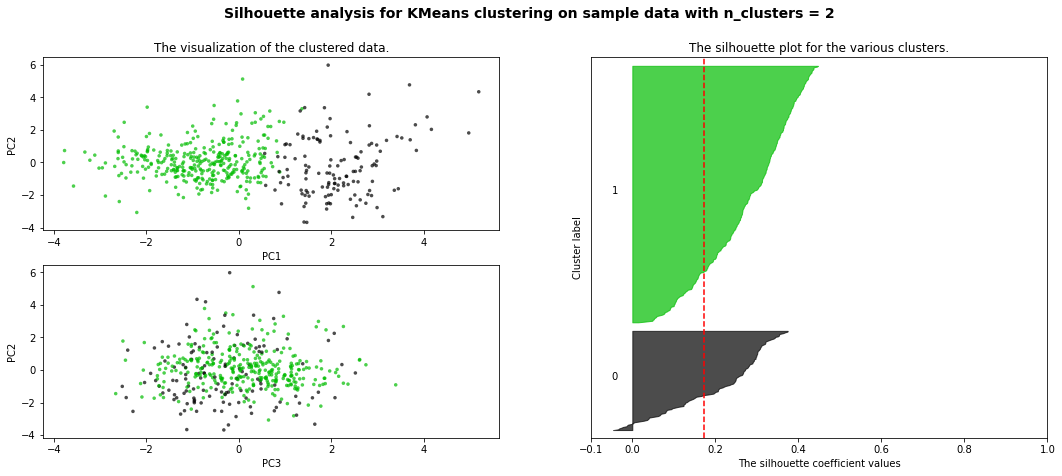

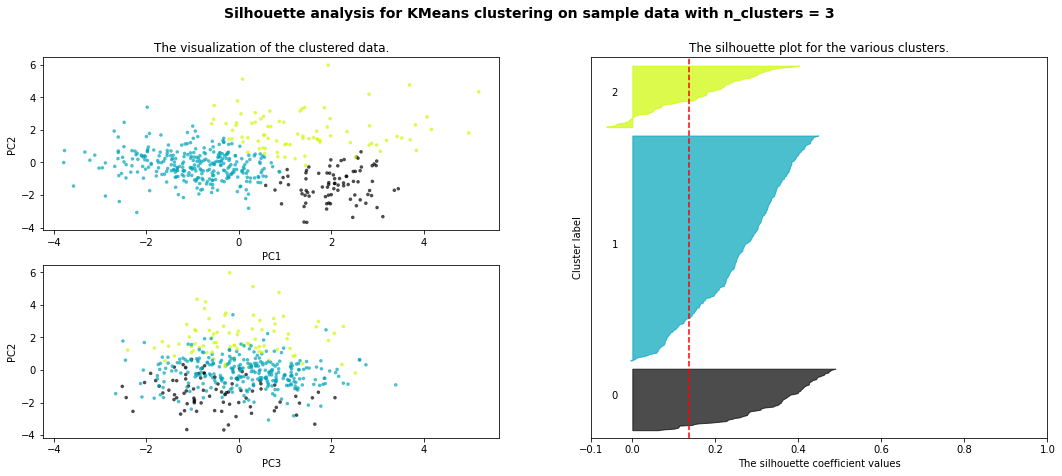

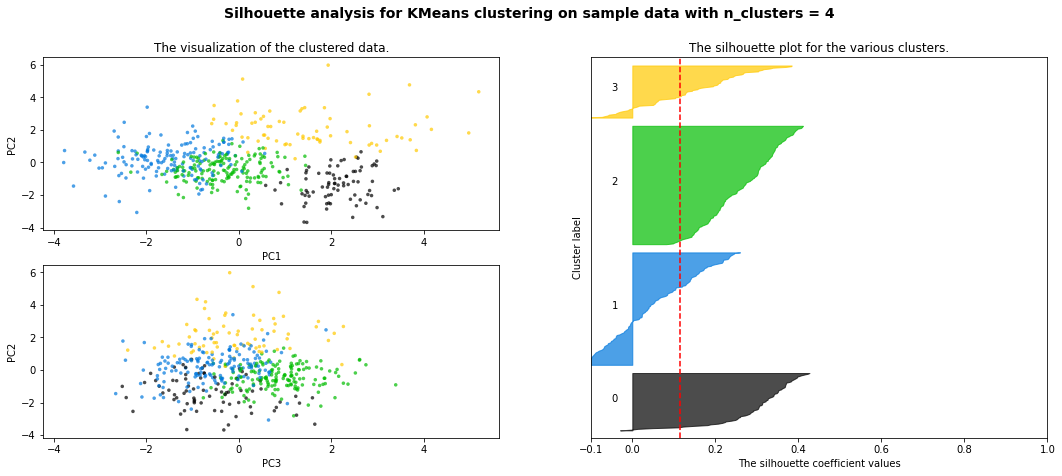

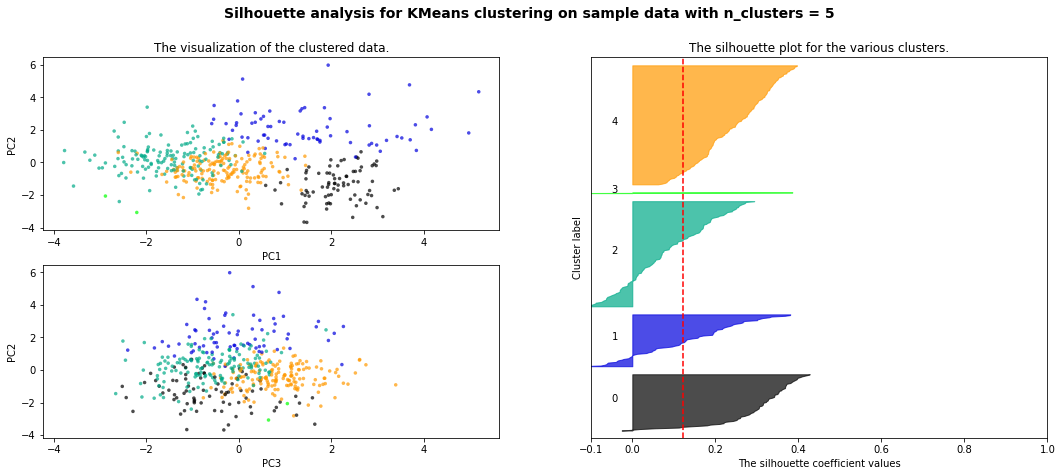

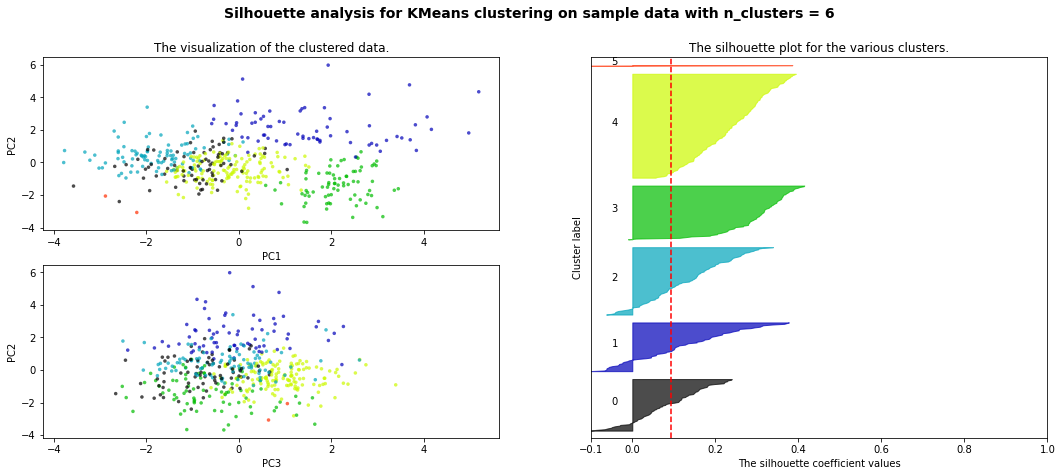

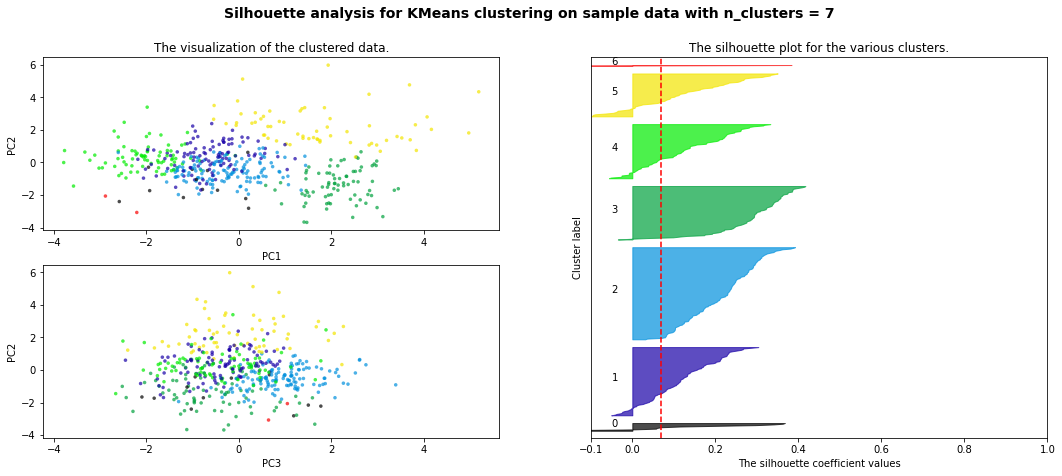

In [60]:
silhouette_scores = []

for n_clusters in range(2, 8):
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure()
    ax1 = fig.add_subplot(221) 
    ax2 = fig.add_subplot(223, sharex=ax1)
    ax3 = fig.add_subplot(122)
    
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax3.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax3.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=1000, max_iter=1000, tol=1e-4)
    cluster_labels = clusterer.fit_predict(Xs)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xs, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax3.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax3.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax3.set_title("The silhouette plot for the various clusters.")
    ax3.set_xlabel("The silhouette coefficient values")
    ax3.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax3.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax3.set_yticks([])  # Clear the yaxis labels / ticks
    ax3.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax1.scatter(
        PCA_proj[:, 0], PCA_proj[:, 1], 
        marker=".", s=50, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    
    ax2.scatter(
        PCA_proj[:, 2], PCA_proj[:, 1], 
        marker=".", s=50, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    ax1.set_title("The visualization of the clustered data.")
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    
    ax2.set_xlabel("PC3")
    ax2.set_ylabel("PC2")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

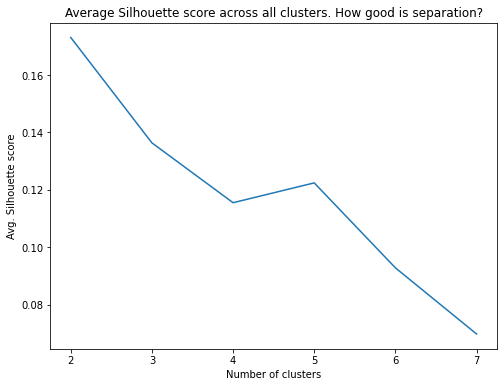

In [61]:
plt.figure(figsize=(8,6))
plt.plot(range(2, 8), silhouette_scores)
plt.title("Average Silhouette score across all clusters. How good is separation?")
plt.xlabel("Number of clusters")
plt.ylabel("Avg. Silhouette score")
plt.show()

<p><b>Conculsion of Silhouette Analysis:</b> We should choose the highest average Silhouette score across all obseravations, this will allow us to have the best separation of the clusters with less overlaps.</p>

In [62]:
# Kmeans with 3 clusters
kmeans = KMeans(n_clusters=3, n_init=1000, max_iter=1000, tol=1e-4)
df_pca["kmeans_3"] = kmeans.fit_predict(Xs)

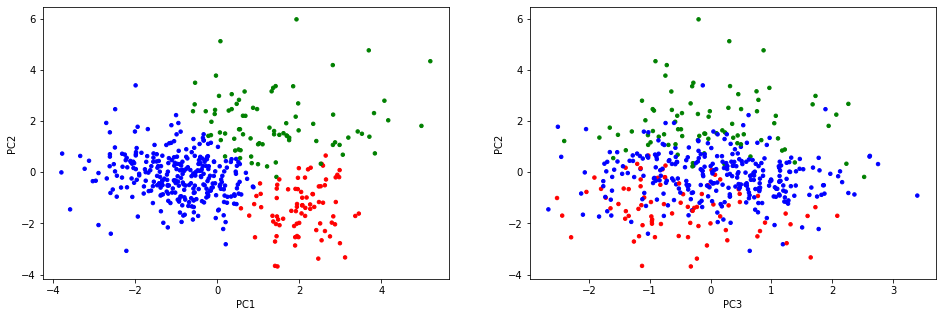

In [63]:
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122)

colors = df_pca["kmeans_3"].map({
    0: "red",
    1: "blue",
    2: "green",
}).tolist()

ax1.scatter(PCA_proj[:, 0], PCA_proj[:, 1], c=colors, alpha=1, s=12)
ax2.scatter(PCA_proj[:, 2], PCA_proj[:, 1], c=colors, alpha=1, s=12)

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax2.set_xlabel("PC3")
ax2.set_ylabel("PC2")

plt.show()

In [64]:
# Kmeans with 4 clusters
kmeans = KMeans(n_clusters=4, n_init=1000, max_iter=1000, tol=1e-4)
df_pca["kmeans_4"] = kmeans.fit_predict(Xs)

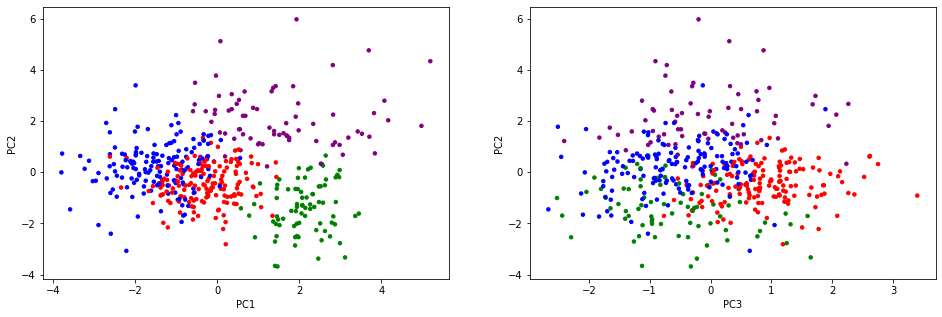

In [65]:
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122)

colors = df_pca["kmeans_4"].map({
    0: "red",
    1: "blue",
    2: "green",
    3: "purple"
}).tolist()

ax1.scatter(PCA_proj[:, 0], PCA_proj[:, 1], c=colors, alpha=1, s=12)
ax2.scatter(PCA_proj[:, 2], PCA_proj[:, 1], c=colors, alpha=1, s=12)

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax2.set_xlabel("PC3")
ax2.set_ylabel("PC2")

plt.show()

In [66]:
# Kmeans with 5 clusters
kmeans = KMeans(n_clusters=5, n_init=1000, max_iter=1000, tol=1e-4)
df_pca["kmeans_5"] = kmeans.fit_predict(Xs)

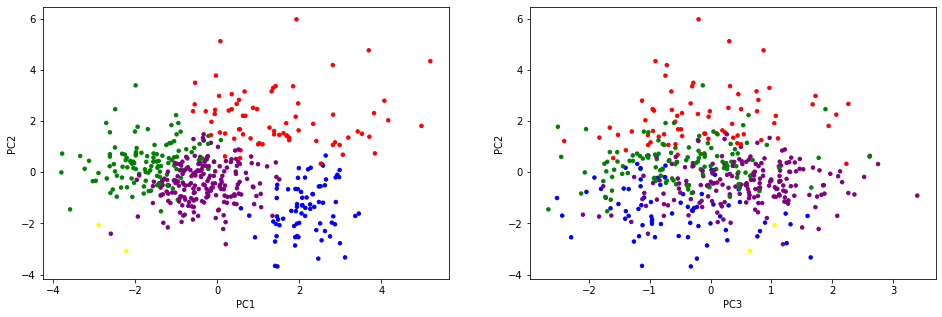

In [67]:
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122)

colors = df_pca["kmeans_5"].map({
    0: "red",
    1: "blue",
    2: "green",
    3: "purple",
    4: "yellow"
}).tolist()

ax1.scatter(PCA_proj[:, 0], PCA_proj[:, 1], c=colors, alpha=1, s=12)
ax2.scatter(PCA_proj[:, 2], PCA_proj[:, 1], c=colors, alpha=1, s=12)

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax2.set_xlabel("PC3")
ax2.set_ylabel("PC2")

plt.show()

<h3>PCA plot with correlations of PCs colored by Kmeans</h3>

In [68]:
colors = df_pca["kmeans_4"].map({
    0: "red",
    1: "blue",
    2: "green",
    3: "purple",
}).tolist()

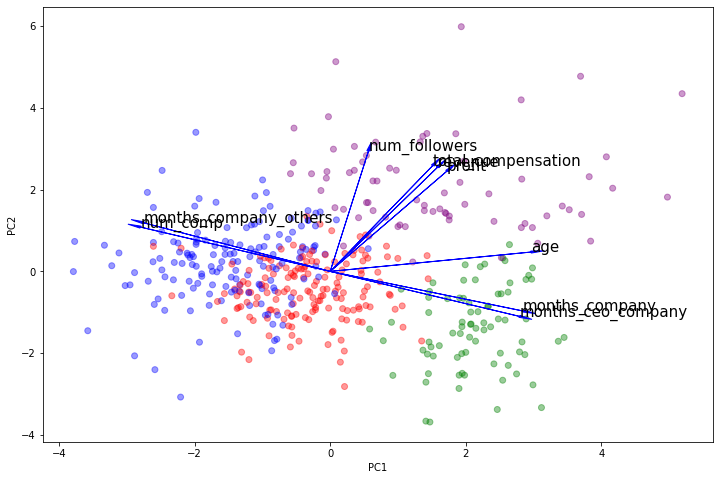

In [69]:
# PCA plot with correlations of PCs to variables
plt.figure(figsize=(12, 8))

plt.scatter(PCA_proj[:, 0], PCA_proj[:, 1], c=colors, alpha=0.4)

for i, col in enumerate(columns_analysis):
    V_norm = Corr[i, 0:2] / np.linalg.norm(Corr[i, 0:2]) * 3
    plt.annotate(col, V_norm, fontsize=15)
    plt.arrow(0, 0, *V_norm, head_width=0.05, head_length=0.2, color="blue")

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

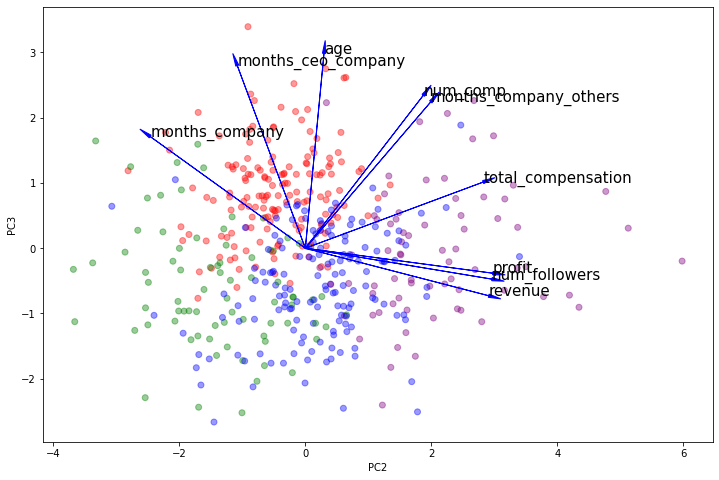

In [70]:
# PCA plot with correlations of PCs to variables
plt.figure(figsize=(12, 8))

plt.scatter(PCA_proj[:, 1], PCA_proj[:, 2], c=colors, alpha=0.4)

for i, col in enumerate(columns_analysis):
    V_norm = Corr[i, 1:3] / np.linalg.norm(Corr[i, 1:3]) * 3
    plt.annotate(col, V_norm, fontsize=15)
    plt.arrow(0, 0, *V_norm, head_width=0.05, head_length=0.2, color="blue")

plt.xlabel("PC2")
plt.ylabel("PC3")

plt.show()

<h3>KMeans++ clustering with Manhattan distances</h3>
<p>KMeans implementation from sklearn doesnt allow to use non-Euclidean metrics, so we resorted to another lesser known 3rd party library. Implementation from pyclustering: <a href="https://github.com/annoviko/pyclustering">Github</a></p>

In [71]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.silhouette import silhouette

In [72]:
# kmeans++ uses another ways to choose initial centers
# function returns result similar to n_init kmeans from sklearn
# we get as an output matrix of number of time datapoint has been assigned to which cluster
def run_kmeans(Xs, n_clusters, n_reps=100):
    final_clusters = np.zeros((Xs.shape[0], n_clusters))
    for i in range(n_reps):
        initial_centers = kmeans_plusplus_initializer(Xs, n_clusters).initialize() 
        manhattan_metric = distance_metric(type_metric.MANHATTAN)
        kmeans_instance = kmeans(
            Xs, initial_centers, metric=manhattan_metric, itermax=10000, tolearance=1e-5, core=True
        )
        # Run cluster analysis and obtain results.
        kmeans_instance.process()
        clusters = kmeans_instance.get_clusters()
        for i, cluster in enumerate(clusters):
            final_clusters[cluster, i] += 1
    return final_clusters

In [73]:
assigns = run_kmeans(Xs, n_clusters=4, n_reps=1000)
assigns

array([[ 91., 648., 181.,  80.],
       [213., 258., 296., 233.],
       [ 90., 646., 183.,  81.],
       ...,
       [411.,  72., 214., 303.],
       [301.,  93., 301., 305.],
       [411.,  74., 213., 302.]])

In [74]:
# choose the most likely cluster which corresponds to maximum number of times datapoint has been assigned to
clusters = assigns.argmax(axis=1)

In [75]:
df_pca["kmeans_manhattan"] = clusters
df_pca["kmeans_manhattan"].value_counts()

0    282
3     85
1     83
2     11
Name: kmeans_manhattan, dtype: int64

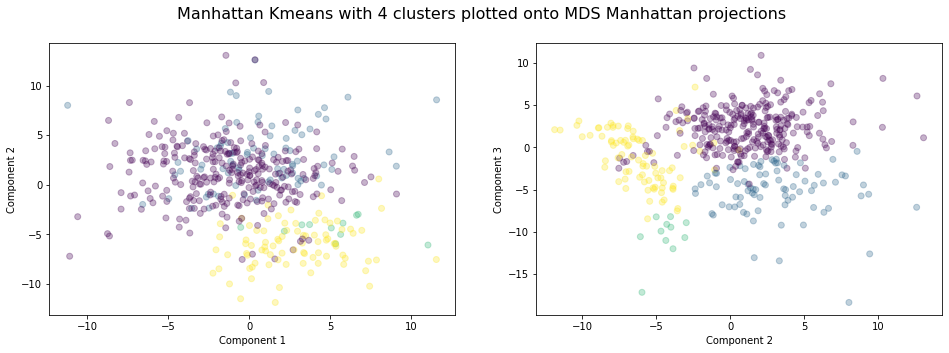

In [76]:
fig = plt.figure(figsize=(16, 5))
fig.suptitle("Manhattan Kmeans with 4 clusters plotted onto MDS Manhattan projections", fontsize=16)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Using 1st and 2nd coordinates of MDS projection
ax1.scatter(Manhattan_res[:, 0], Manhattan_res[:, 1], c=df_pca["kmeans_manhattan"], alpha=0.3)
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")

# Using 2st and 3nd coordinates of MDS projection
ax2.scatter(Manhattan_res[:, 1], Manhattan_res[:, 2], c=df_pca["kmeans_manhattan"], alpha=0.3)
ax2.set_xlabel("Component 2")
ax2.set_ylabel("Component 3")

plt.show()

<h3>3D Plots of final results</h3>

In [77]:
import plotly.express as px

<h3>Results obtained from KMeans with 4 clusters</h3>

In [78]:
# 3D PCA plot
fig = px.scatter_3d(
    x=PCA_proj[:, 0],
    y=PCA_proj[:, 1],
    z=PCA_proj[:, 2],
    color=df_pca["kmeans_4"],
    size_max=3
)

fig.show()

<h3>Results obtained from Kmeans with manhattan distances and 5 clusters</h3>

In [79]:
fig = px.scatter_3d(
    x=Manhattan_res[:, 0],
    y=Manhattan_res[:, 1],
    z=Manhattan_res[:, 2],
    color=df_pca["kmeans_manhattan"],
    size_max=3
)

fig.show()

<h3>Boostrap KMeans</h3>

In [80]:
def bootstrap_kmeans(n_clusters, n_samples=100):
    
    counts = np.zeros((Xs.shape[0], n_clusters)) 
    assigned_to = np.zeros((Xs.shape[0], n_clusters))
    
    for i in tqdm(range(n_samples)):
        indecies = np.random.choice(Xs.shape[0], size=Xs.shape[0], replace=True)
        Xb = Xs[indecies, :]
        kmeans = KMeans(
            n_clusters=n_clusters, n_init=1000, max_iter=1000,
            tol=1e-4
        )
        assigned_groups = kmeans.fit_predict(Xb)
        # calculate number of occurances and assignments to each class
        counts[indecies] += 1
        for j in indecies:
            assigned_to[j, assigned_groups[j]] += 1
            
    return np.mean(assigned_to / counts, axis=0)

In [86]:
# Check cluster assignment stability
bootstrap_res = bootstrap_kmeans(n_clusters=4, n_samples=100)

In [82]:
bootstrap_res

array([0.48210175, 0.4095153 , 0.3562456 , 0.33115302])

<h3>Studying final clusters</h3>

In [83]:
df_clear["kmeans_4"] = df_pca["kmeans_4"].tolist()
df_clear["kmeans_manhattan"] = df_pca["kmeans_manhattan"].tolist()

<h4>KMeans clusters statistics</h4>

In [84]:
df_clear.iloc[:, 2:].groupby("kmeans_4").agg(["mean"]).style.background_gradient(axis=0)

<h4>Manhattan Kmeans clusters statistics</h4>

In [85]:
df_clear.iloc[:, 2:].groupby("kmeans_manhattan").agg(["mean"]).style.background_gradient(axis=0)

<h3>Trying to explain difference between clusters using sectors</h3>